# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import findspark
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import  ClusteringEvaluator
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType,IntegerType
from pyspark.sql import functions as f

# **Install Requirment**

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [5]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [6]:
!pip install -q findspark

# **Setup Envirment**

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [8]:

findspark.init()

In [9]:
findspark.find()

'/content/spark-3.1.1-bin-hadoop2.7'

In [14]:
spark = SparkSession.builder.appName('kmeans').getOrCreate()

# **Load Datasets**

In [15]:
df = spark.read.csv("/content/seeds_dataset.csv",header=True,inferSchema=True)

In [16]:
df.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.175|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
only showing top 5 rows



In [17]:
df.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

In [18]:
df.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

# **VectorAssembler**

In [20]:
assembler = VectorAssembler(inputCols=df.columns,outputCol='features')

In [21]:
df_final = assembler.transform(df)

In [22]:
df_final.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|            features|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|             4.805|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355| 

# **Scaling**

In [24]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [25]:
scaledModel = scaler.fit(df_final)

In [26]:
df_final = scaledModel.transform(df_final)

In [143]:
df_final.show(2)

+-----+---------+-----------+-----------------+---------------+---------------------+----------------+--------------------+--------------------+
| area|perimeter|compactness| length_of_kernel|width_of_kernel|asymmetry_coefficient|length_of_groove|            features|      scaledFeatures|
+-----+---------+-----------+-----------------+---------------+---------------------+----------------+--------------------+--------------------+
|15.26|    14.84|      0.871|            5.763|          3.312|                2.221|            5.22|[15.26,14.84,0.87...|[5.24452795332028...|
|14.88|    14.57|     0.8811|5.553999999999999|          3.333|                1.018|           4.956|[14.88,14.57,0.88...|[5.11393027165175...|
+-----+---------+-----------+-----------------+---------------+---------------------+----------------+--------------------+--------------------+
only showing top 2 rows



# **Implement Kmeans**


In [28]:
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(df_final)

In [29]:
pred = model.transform(df_final)

# **Evaluate**

In [30]:
eval = ClusteringEvaluator()
silhouette = eval.evaluate(pred)
print(f'silhouette with squared eculidean distance : {silhouette}')

silhouette with squared eculidean distance : 0.6300001033389961


# **Centers**

In [31]:
centers = model.clusterCenters()
print('cluster center')
for center in centers:
  print(center)

cluster center
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]


# **Prediction**

In [32]:
transformed = model.transform(df_final).select('prediction')
rows = transformed.collect()
print(rows[:3])

[Row(prediction=2), Row(prediction=2), Row(prediction=2)]


In [33]:
print(len(rows))

210


In [34]:
rows[100:103]

[Row(prediction=0), Row(prediction=0), Row(prediction=0)]

In [36]:
type(rows)

list

In [59]:
print(len(rows))

210


# **Create DataFrame of prediction**

In [62]:
rdd = spark.sparkContext.parallelize(rows)

In [63]:
schema = StructType([
    StructField('prediction', IntegerType(), True)
])

In [64]:
df_2 = spark.createDataFrame(rdd,schema)
print(df_2.schema)

StructType(List(StructField(prediction,IntegerType,true)))


In [65]:
df_2.columns

['prediction']

In [84]:
df_2.count()

210

In [85]:
df_final.count()

210

# **Convert to Pandas DataFrame**

In [87]:
prediction_df = df_2.toPandas()

In [88]:
prediction_df.shape

(210, 1)

In [89]:
final_df.shape

(210, 9)

# **pre-process Data**

In [91]:
final_df.drop(['features','scaledFeatures'],axis=1,inplace=True)

In [177]:
center1=[6.35645488,12.40730852,37.41990178,13.93860446,9.7892399,2.41585013,12.29286107]
center2=[4.07497225,10.14410142,35.89816849,11.80812742,7.54416916,3.15410901,10.38031464]
center3=[4.96198582,10.97871333,37.30930808,12.44647267,8.62880781,1.80061978,10.41913733]

In [153]:
feature_df = df_final.toPandas()

In [154]:
feature_df = feature_df.loc[:,'scaledFeatures']

In [156]:
first = []
two=[]
three=[]
four=[]
five=[]
six=[]
seven=[]
for x in feature_df:
  first.append(x[0])
  two.append(x[1])
  three.append(x[2])
  four.append(x[3])
  five.append(x[4])
  six.append(x[5])
  seven.append(x[6])
  
li = []
li.append(first)
li.append(two)
li.append(three)
li.append(four)
li.append(six)
li.append(five)
li.append(seven)
print(len(li))

7


In [171]:
frame = { 'area': pd.Series(first), 'perimeter': pd.Series(two),'compactness': pd.Series(three),
         'length_of_kernel': pd.Series(four),'width_of_kernel': pd.Series(five) ,'asymmetry_coefficient': pd.Series(six), 'length_of_groove':pd.Series(seven) }
df_fe = pd.DataFrame(frame)

df_fe=pd.concat([df_fe,prediction_df])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# **Clusters**

In [ ]:
cluster1 = df_fe[df_concat.prediction==0]
cluster2 = df_fe[df_concat.prediction==1]
cluster3 = df_fe[df_concat.prediction==2]

# **Plot centroid in clusters**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you m

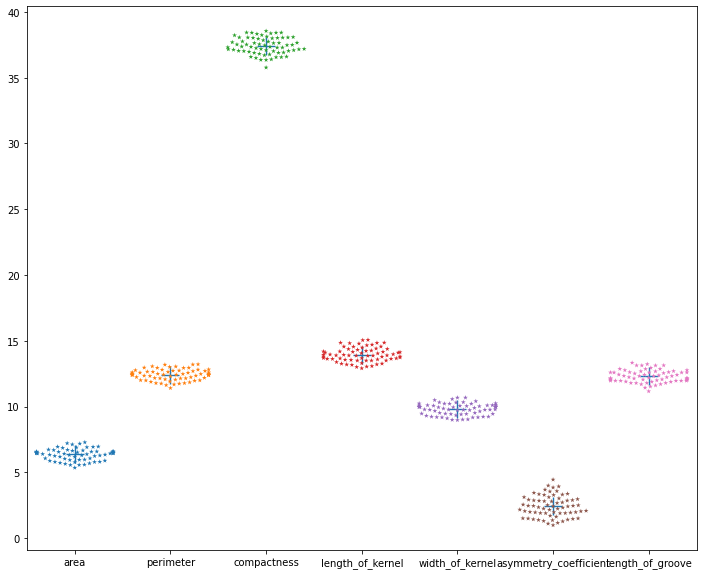

In [191]:
plt.figure(figsize=(12,10))
sns.swarmplot(data=cluster1.iloc[:,:7],marker="*")
sns.scatterplot(data=pd.Series(center1),s=300,marker="+",alpha=1)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; y

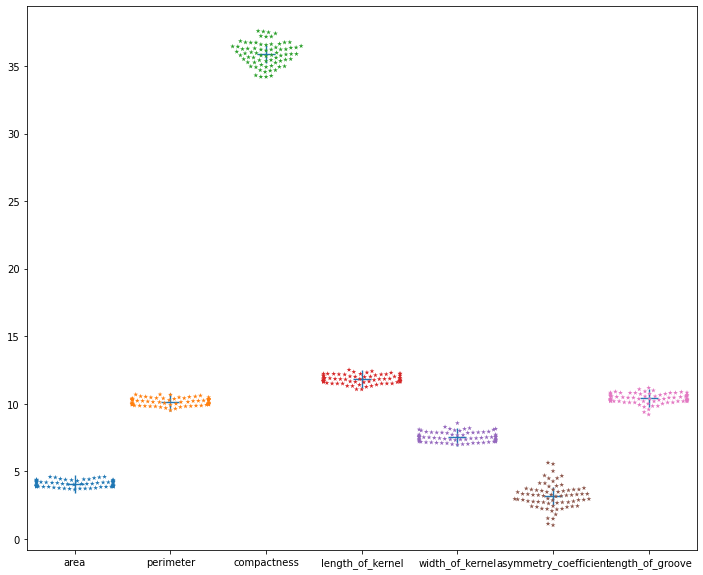

In [190]:
plt.figure(figsize=(12,10))
sns.swarmplot(data=cluster2.iloc[:,:7],marker="*")
sns.scatterplot(data=pd.Series(center2),marker="+",s=300,alpha=1)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


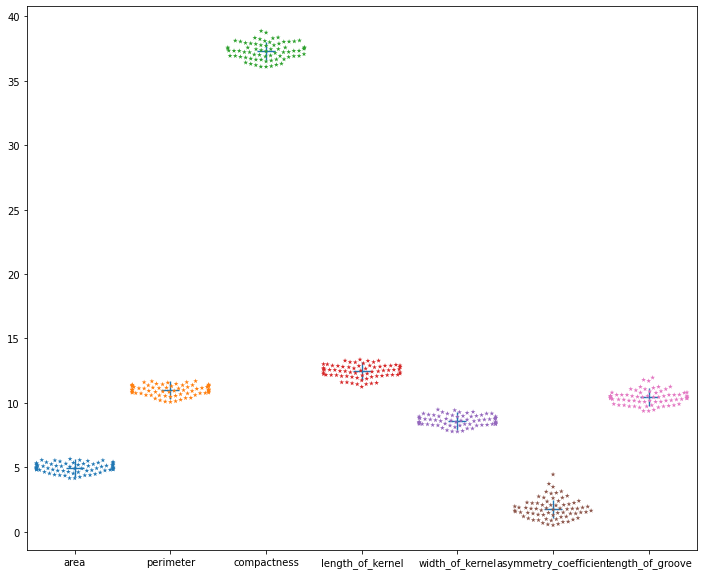

In [189]:
plt.figure(figsize=(12,10))
sns.swarmplot(data=cluster3.iloc[:,:7],marker="*")
sns.scatterplot(data=pd.Series(center3),s=300,marker="+",alpha=1)

plt.show()